In [ ]:
# Bias Categories

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("./dummycsv.csv")

In [3]:
data

,path,gender,age
0,xyc.jpg,male,young
1,abc.png,female,old
2,abc.jpg,male,middle
3,teate.jpg,female,young
4,asdas.png,male,old


In [4]:
y_pred_gender = ["male", "female", "female", "female", "male"]
y_true_gender = data["gender"]

In [5]:
male_correct_count_gender = 0
female_correct_count_gender = 0
for i in range(data.shape[0]):
    if(y_true_gender[i]=="male" and y_pred_gender[i]=="male"):
        male_correct_count_gender+=1
    if(y_true_gender[i]=="female" and y_pred_gender[i]=="female"):
        female_correct_count_gender+=1
print(male_correct_count_gender, female_correct_count_gender)

2 2


In [6]:
y_pred_age = ["young", "old", "old", "middle", "young"]
y_true_age = data["age"]

In [7]:
young_correct_count_age = 0
middle_correct_count_age = 0
old_correct_count_age = 0
for i in range(data.shape[0]):
    if(y_true_age[i]=="young" and y_pred_age[i]=="young"):
        young_correct_count_age+=1
    if(y_true_age[i]=="middle" and y_pred_age[i]=="middle"):
        middle_correct_count_age+=1
    if(y_true_age[i]=="old" and y_pred_age[i]=="old"):
        old_correct_count_age+=1
print(young_correct_count_age, middle_correct_count_age, old_correct_count_age)

1 0 1


In [ ]:
# Confusion matrix and performance evaluation metrics for bias categories

In [2]:
import numpy as np
import torch

In [8]:
device = "cuda"
final_model = torch.load(f'models/final_model.pth').to(device)

In [9]:
from torchsummary import summary
summary(final_model, input_size=(3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 96, 96]           1,520
         MaxPool2d-2           [-1, 20, 47, 47]               0
            Conv2d-3           [-1, 50, 43, 43]          25,050
         MaxPool2d-4           [-1, 50, 21, 21]               0
            Conv2d-5          [-1, 100, 17, 17]         125,100
         MaxPool2d-6            [-1, 100, 8, 8]               0
            Conv2d-7            [-1, 200, 4, 4]         500,200
         MaxPool2d-8            [-1, 200, 1, 1]               0
            Linear-9                  [-1, 800]         160,800
           Linear-10                  [-1, 120]          96,120
           Linear-11                    [-1, 5]             605
       LogSoftmax-12                    [-1, 5]               0
Total params: 909,395
Trainable params: 909,395
Non-trainable params: 0
-------------------------------

In [19]:
import os, csv
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

BATCH_SIZE = 25

data_transform = transforms.Compose([
    transforms.Resize(125),
    transforms.CenterCrop(100),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

testData = datasets.ImageFolder(
    root="./dataset/test",
    transform=data_transform
)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

print("TESTING:")
# On the test set
with torch.no_grad():
    # set the model in evaluation mode
    final_model.eval()

    # initialize a list to store our predictions
    y_pred = []
    y_true = []

    for inputs, labels in testDataLoader:
        inputs = inputs.to(device)
        outputs = final_model(inputs)  # Feed Network
        outputs = outputs.argmax(axis=1).cpu().numpy()
        y_pred.extend(outputs)  # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # Save Truth

    # constant for classes
    classes = testData.classes


# csv.reader("C:\Users\Intel\Downloads\Test_Dataset_Categories", "Excel")

# indeces as class
testMales = [34, 35, 43, 50, 69]
testFemales = [66, 65, 57, 50, 31]
testYoung = [31, 33, 24, 27, 38]
testMiddle = [49, 41, 57, 53, 56]
testOld = [20, 26, 19, 20, 16]
# each index here should sum to 100

ageList = []
genderList = []

MaleIndex = []
FemaleIndex = []
YoungIndex = []
MiddleIndex = []
OldIndex = []

with open(os.path.join('dataset', 'test', 'Test_Dataset_Categories_List.csv'), newline='') as csvfile:
    reader = csv.reader(csvfile, 'excel')
    i = 0
    for row in reader:
        if row[0] == '' or row[1] == "Age":
            continue
        ageList.append(row[1])
        genderList.append(row[2])
        if row[1] == "Old":
            OldIndex.append(i)
        if row[1] == "Middle":
            MiddleIndex.append(i)
        if row[1] == "Young":
            YoungIndex.append(i)
        if row[2] == "Male":
            MaleIndex.append(i)
        if row[2] == "Female":
            FemaleIndex.append(i)
        i += 1

malesByClass = [0, 0, 0, 0, 0]
femalesByClass = [0, 0, 0, 0, 0]
youngByClass = [0, 0, 0, 0, 0]
middleByClass = [0, 0, 0, 0, 0]
oldByClass = [0, 0, 0, 0, 0]
for i in range(len(testData.imgs)):
    if y_pred[i] == y_true[i]:
        outputClass = y_true[i]

        gender = genderList[i]
        age = ageList[i]

        if gender == "Male":
            malesByClass[outputClass] += 1
        else:
            femalesByClass[outputClass] += 1

        if age == "Young":
            youngByClass[outputClass] += 1
        elif age == "Middle":
            middleByClass[outputClass] += 1
        else:
            oldByClass[outputClass] += 1

print("Accuracy per class for Gender and Age biases:")
print("Class - Male - Female - Young - Middle - Old")
for i in range(5):
    print(f"  {i}  -  "
          f"{'{0:.0f}'.format(malesByClass[i] / testMales[i] * 100)}%  -  "
          f"{'{0:.0f}'.format(femalesByClass[i] / testFemales[i] * 100)}%  -  "
          f"{'{0:.0f}'.format(youngByClass[i] / testYoung[i] * 100)}%  -  "
          f"{'{0:.0f}'.format(middleByClass[i] / testMiddle[i] * 100)}%  -  "
          f"{'{0:.0f}'.format(oldByClass[i] / testOld[i] * 100)}%")


TESTING:
Accuracy per class for Gender and Age biases:
Class - Male - Female - Young - Middle - Old
  0  -  97%  -  98%  -  100%  -  96%  -  100%
  1  -  54%  -  68%  -  45%  -  73%  -  69%
  2  -  86%  -  96%  -  92%  -  96%  -  79%
  3  -  80%  -  82%  -  85%  -  77%  -  85%
  4  -  33%  -  29%  -  16%  -  32%  -  50%


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [66]:
# Confusion matrices for given bias category
classes = testData.classes
def save_bias_category(y_true, y_pred, bias_idx, bias_name):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    bias_idx = np.array(bias_idx)
    # Filter the bias category samples
    y_true = y_true[bias_idx]
    y_pred = y_pred[bias_idx]
    
    cf_matrix = confusion_matrix(y_true, y_pred)    
    df_cm = pd.DataFrame(cf_matrix, index=[i for i in classes],
                         columns=[i for i in classes])
    
    plt.figure(figsize=(12, 7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig(f'./bias_evaluations/cf_matrix_{bias_name}.png')
    print(f"Saved test confusion matrix for {bias_name}")

    with open(f"./bias_evaluations/eval_metrics_{bias_name}.txt", "w") as f:
        f.write(classification_report(y_true,
                                      y_pred, target_names=testData.classes))
    print(f"Saved test evaluation metrics for {bias_name}")

Saved test confusion matrix for male
Saved test evaluation metrics for male
Saved test confusion matrix for female
Saved test evaluation metrics for female
Saved test confusion matrix for young
Saved test evaluation metrics for young
Saved test confusion matrix for middle
Saved test evaluation metrics for middle
Saved test confusion matrix for old
Saved test evaluation metrics for old


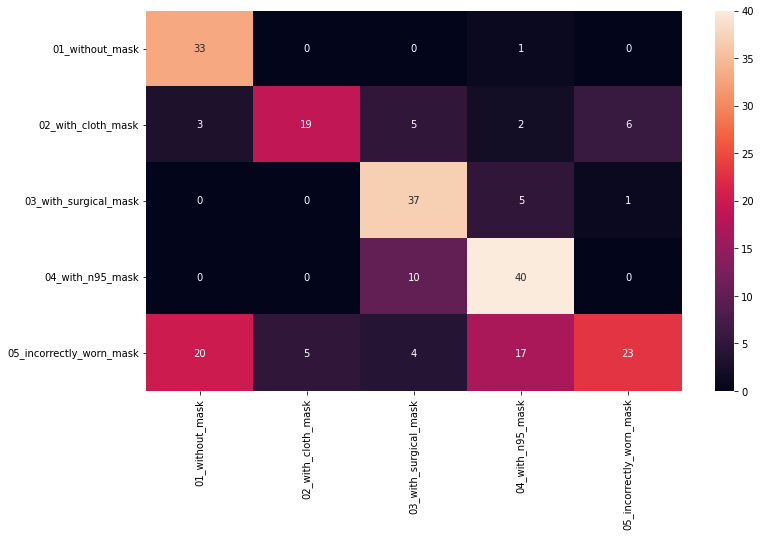

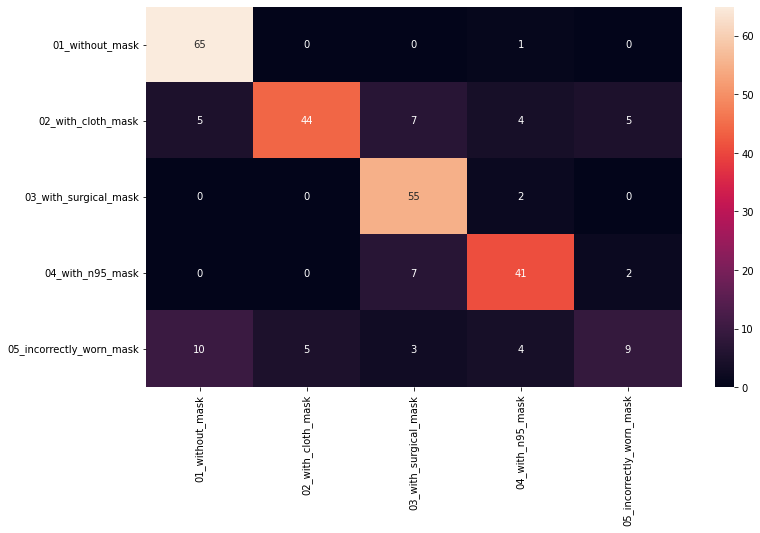

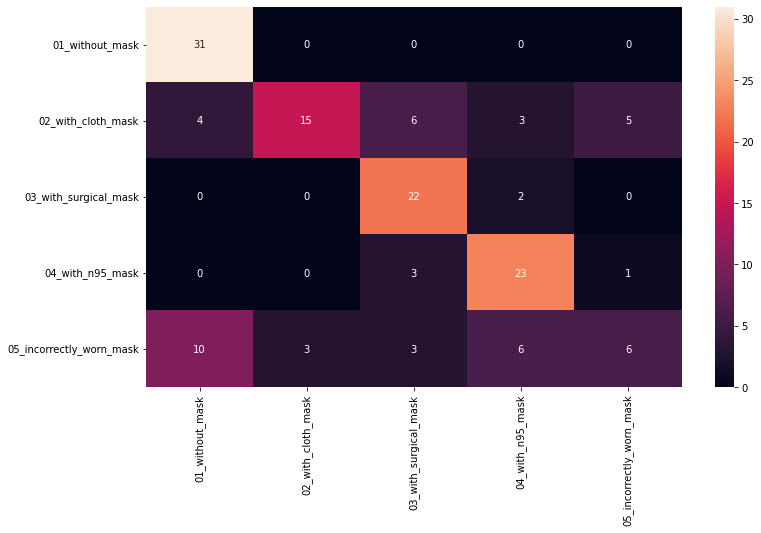

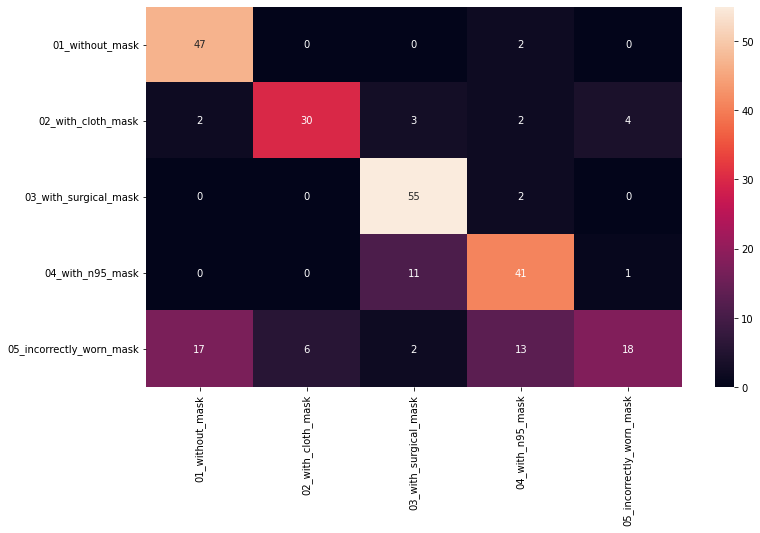

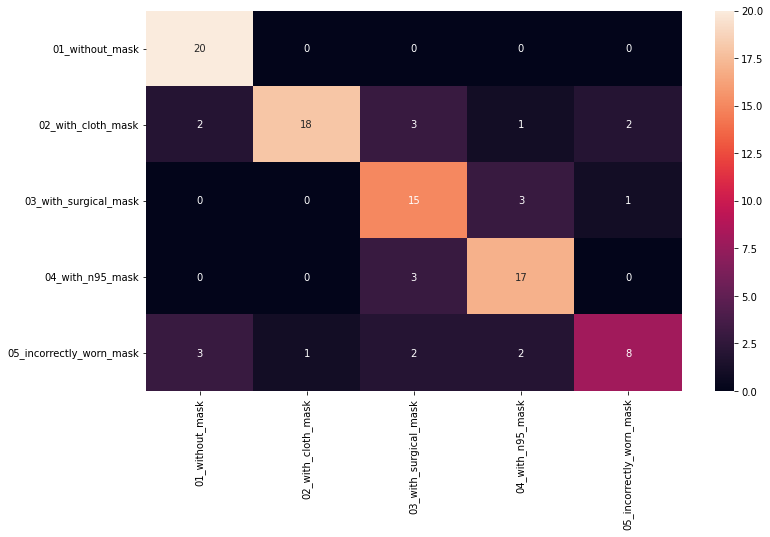

In [67]:
save_bias_category(y_true, y_pred, MaleIndex, "male")
save_bias_category(y_true, y_pred, FemaleIndex, "female")
save_bias_category(y_true, y_pred, YoungIndex, "young")
save_bias_category(y_true, y_pred, MiddleIndex, "middle")
save_bias_category(y_true, y_pred, OldIndex, "old")